# Project 2

# Purpose

This [November 2021 CNBC article](https://www.cnbc.com/2021/11/09/bitcoin-vs-gold-leading-gold-authorities-on-inflation-hedge-battle.html) on Bitcoin and gold as inflation and market risk hedges motivated this project.
I have two goals for this project:

1. To help you master data analysis
1. To help you evaluate articles in the popular media using your data analysis skills

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.float_format', '{:.4f}'.format)
%precision 2
%config InlineBackend.figure_format = 'retina'

In [3]:
import yfinance as yf
import pandas_datareader as pdr
import requests_cache
session = requests_cache.CachedSession()

In [4]:
import scipy.optimize as sco
import seaborn as sns
import statsmodels.formula.api as smf

# Tasks

## Task 1: Do Bitcoin and gold hedge inflation risk?

Use the typical finance definition of [hedge](https://www.investopedia.com/terms/h/hedge.asp):

> To hedge, in finance, is to take an offsetting position in an asset or investment that reduces the price risk of an existing position. A hedge is therefore a trade that is made with the purpose of reducing the risk of adverse price movements in another asset. Normally, a hedge consists of taking the opposite position in a related security or in a derivative security based on the asset to be hedged. 

Here are a few suggestions:

1. Measure Bitcoin's price with [BTC-USD](https://finance.yahoo.com/quote/BTC-USD?p=BTC-USD&.tsrc=fin-srch) and gold's price with [GLD](https://finance.yahoo.com/quote/GLD?p=GLD&.tsrc=fin-srch)
1. Throughout the project, assume Bitcoin and U.S. public equity markets have the same closing time
1. Measure the price level with [PCEPI](https://fred.stlouisfed.org/series/PCEPI/) from the Federal Reserve Database (FRED), which is downloadable with `pdr.DataReader()`
1. Measure inflation (i.e., the rate of change in the price level) as the percent change in PCEPI

Text(0.5, 1.0, 'Inflation')

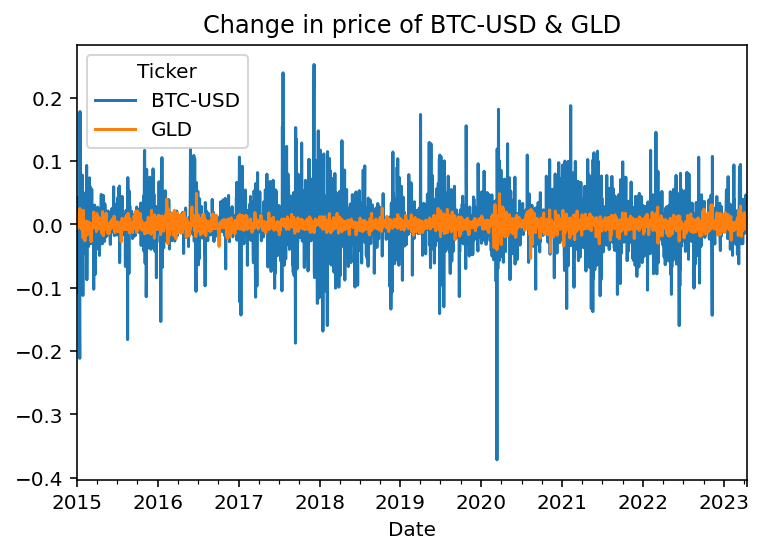

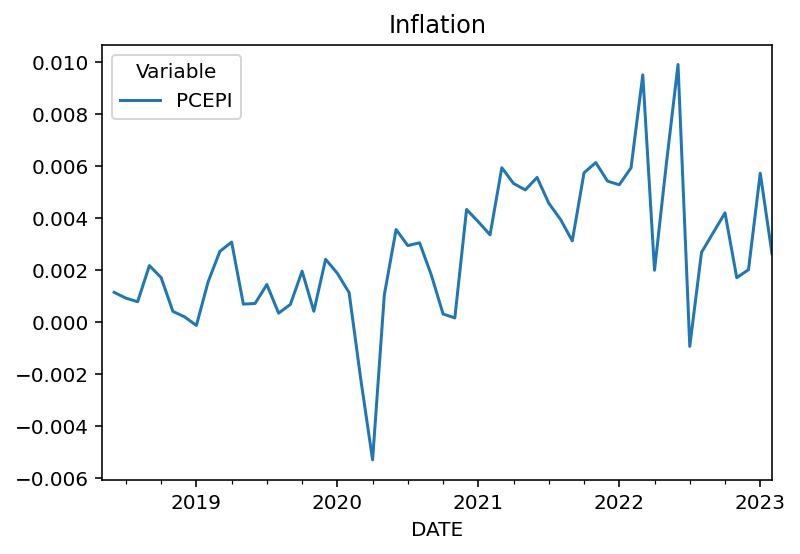

In [5]:
# BTC-USD & GLD
tickers = 'BTC-USD GLD'
matana = (
    yf.download(tickers=tickers, progress=False)
    .assign(Date=lambda x: x.index.tz_localize(None))
    .set_index('Date')
    .rename_axis(columns=['Variable', 'Ticker'])
)
returns_1 = matana['Adj Close'].pct_change().loc['2015':]
returns_1.plot()
plt.title('Change in price of BTC-USD & GLD')

# PCEPI
pcepi = pdr.DataReader(
    name = 'PCEPI',
    data_source = 'fred',
    session = session,
).rename_axis(columns='Variable')
inflation = pcepi.pct_change()
inflation.plot()
plt.title('Inflation')

Yes, Both Bitcoin and gold can be considered as potential hedges against inflation risk. But from the graph, we can see that Gold are more stable than Bitcoin. Investors purchase gold to hedge inflation for a long history. When inflation rises, the purchasing power of most of currency declines, and investors tend to consider gold as a safety asset. Gold can also hold value in times of economic uncertainty and political instability. Bitcoin are a new digital asset that track lots of attentation in recently years. Although bitcoin value is not tied to any government currencies or central authority, it will affect by the government restrictions. Bitcoin are more volatile comparing to Gold, Bitcoin price can be increase 17% in one day meanwhile it can also fell by more than 80%. From the Graphs, both bitcoin and inflation has a sharp decline in the first quarter in 2020 due to the global COVID-19 pandemic and its impact on the economy. Investors are selling in the stock market try to move their money into cash. The pandemic caused a significant drop in demand for goods and services, as well as supply chain disruptions, which led to a decrease in prices for many products. Banks begin to lower the interest rates and increasing the money supply to mitigate the impact of the pandemic, these all bring down the Inflation in short term. 



## Task 2: Do Bitcoin and gold hedge market risk?

Here are a few suggestions:

1. Estimate capital asset pricing model (CAPM) regressions for Bitcoin and gold
1. Use the daily factor data from Ken French

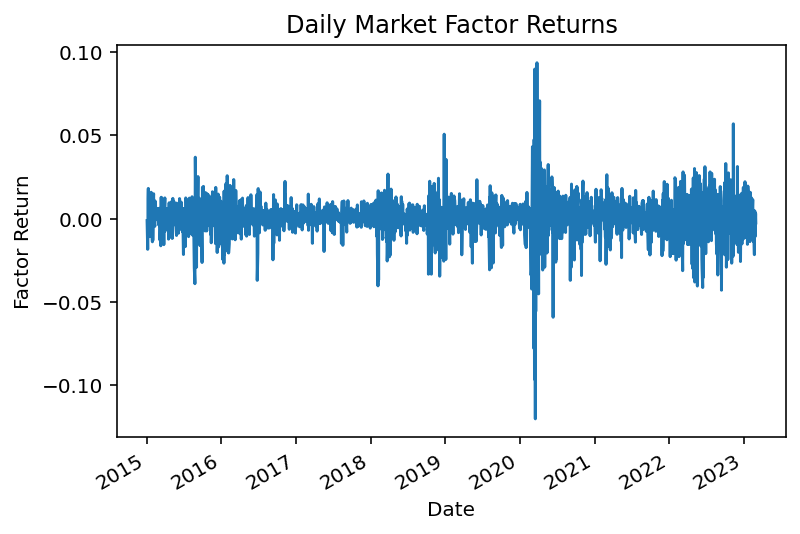

In [28]:
# import French
ff = pdr.DataReader(
        name='F-F_Research_Data_Factors_daily',
        data_source='famafrench',
         start='1900',
         session=session
     )[0].rename_axis(columns='Variable').div(100)
ff['Mkt-RF'].loc['2015':].plot()
plt.title('Daily Market Factor Returns')
plt.xlabel('Date')
plt.ylabel('Factor Return')
plt.show()

def mean(ri, ann=365, mul=100):
    return mul * ann * ri.mean()

def beta(ri, rf=ff['RF'], rm_rf=ff['Mkt-RF']):
    ri_rf = ri.sub(rf).dropna()
    return ri_rf.cov(rm_rf) / rm_rf.loc[ri_rf.index].var()


BTC-USD Beta: 0.7940905434550904
BTC-USD Alpha: 81.82358131933336%

GLD Beta: 0.0255319613827232
GLD Alpha: 7.182823008194068%



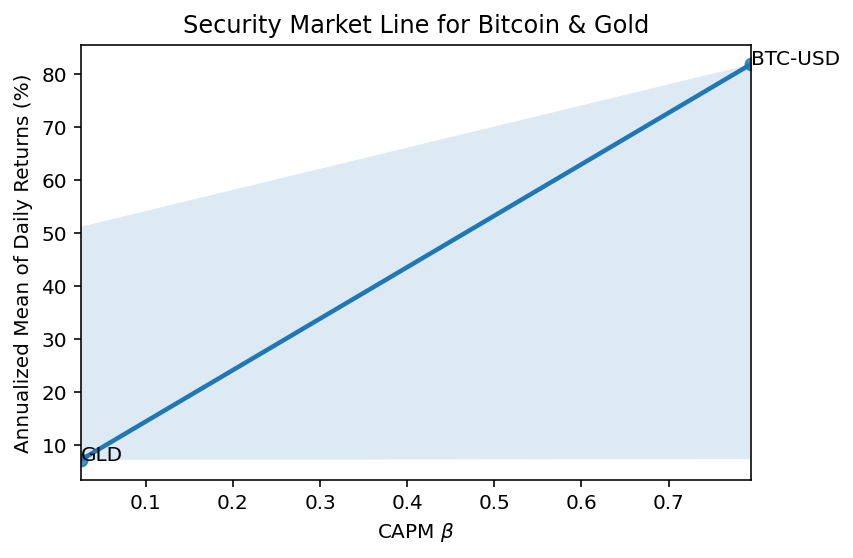

In [57]:
BTC_GLD = (
    returns_1
    .agg([mean, beta])
    .rename_axis(index='Statistic')
    .transpose()
)

sns.regplot(x='beta', y='mean', data=BTC_GLD)
for t, (x, y) in BTC_GLD[['beta', 'mean']].iterrows():
    plt.annotate(text=t, xy=(x, y)) 
    print(t + ' Beta: '+ str(x))
    print(t + ' Alpha: ' + str(y) + '%' +'\n')
    
plt.ylabel('Annualized Mean of Daily Returns (%)')
plt.xlabel(r'CAPM $\beta$')
plt.title('Security Market Line for Bitcoin & Gold')
plt.show()

From the above graphs, Bitcoin and gold can hedge market risk. The annualized mean of daily return of bitcoin and gold are usually higher than market return. Bitcoin has higher return rate come with the higher risk and inflation. Gold are more stable, with lower risk and lower returns. Gold is for long term investment product, bitcoin is for short term investment product. Bitcoin has a higher beta which leads to a higher alpha, A high alpha is always good. A high beta may be preferred by an investor in growth stocks but shunned by investors who seek steady returns and lower risk. Gold has a lower beta and to a lower alpha, people who are risk averse investors.

## Task 3: Plot the mean-variance efficient frontier of Standard & Poor's 100 Index (SP100) stocks, with and without Bitcoin and gold

Here are a few suggestions:

1. You can learn about the SP100 stocks [here](https://en.wikipedia.org/wiki/S%26P_100)
1. Only consider days with complete data for Bitcoin and gold
1. Drop any stocks with shorter return histories than Bitcoin and gold
1. Assume long-only portfolios

In [35]:
# data import
wiki = pd.read_html('https://en.wikipedia.org/wiki/S%26P_100')[2]
#tickers = ''
#for i in wiki['Symbol']:
#    tickers+=str(i)
#    tickers+=' '
#print(tickers)
tickers = 'AAPL ABBV ABT ACN ADBE AIG AMD AMGN AMT AMZN AVGO AXP BA BAC BK BKNG BLK BMY BRK-B C CAT CHTR CL CMCSA COF COP COST CRM CSCO CVS CVX DHR DIS DOW DUK EMR EXC F FDX GD GE GILD GM GOOG GOOGL GS HD HON IBM INTC JNJ JPM KHC KO LIN LLY LMT LOW MA MCD MDLZ MDT MET META MMM MO MRK MS MSFT NEE NFLX NKE NVDA ORCL PEP PFE PG PM PYPL QCOM RTX SBUX SCHW SO SPG T TGT TMO TMUS TSLA TXN UNH UNP UPS USB V VZ WBA WFC WMT XOM'

sp100 = (
    yf.download(tickers=tickers, progress=False)
    .rename_axis(columns=['Variable', 'Ticker'])
)
returns_sp = sp100['Adj Close'].pct_change().dropna()

In [39]:
# functions
def port_vol(x, r, ppy):
    return np.sqrt(ppy) * r.dot(x).std()
def port_mean(x, r, ppy):
    return ppy * r.dot(x).mean()

In [42]:
# EF
tret = 252 * np.linspace(returns_sp.mean().min(), returns_sp.mean().max(), 100)

res_ef = []

for t in tret:
    _ = sco.minimize(
        fun=port_vol, # minimize portfolio volatility
        x0=np.ones(returns_sp.shape[1]) / returns_sp.shape[1], # initial portfolio weights
        args=(returns_sp, 252), # additional arguments to fun, in order
        bounds=[(0, 1) for c in returns_sp.columns], # bounds limit the search space for each portfolio weight
        constraints=(
            {'type': 'eq', 'fun': lambda x: x.sum() - 1}, # constrain sum of weights to one
            {'type': 'eq', 'fun': lambda x: port_mean(x=x, r=returns_sp, ppy=252) - t} # constrains portfolio mean return to the target return

        )
    )
    res_ef.append(_)

In [43]:
ef = pd.DataFrame(
    {
        'tret': tret,
        'tvol': np.array([r['fun'] if r['success'] else np.nan for r in res_ef])
    }
)

ef.head()

,tret,tvol
0,-0.0905,0.2816
1,-0.0815,0.2548
2,-0.0726,0.2310
3,-0.0636,0.2114
4,-0.0547,0.1971


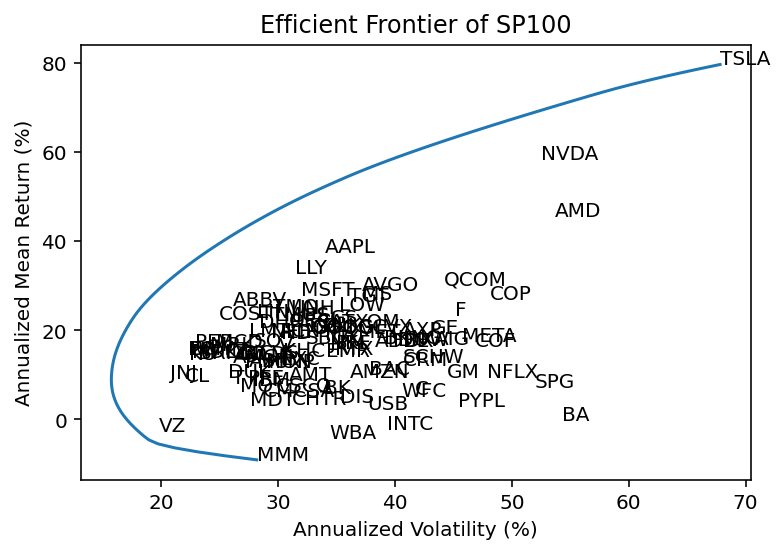

In [54]:
ef.mul(100).plot(x='tvol', y='tret', legend=False)
plt.ylabel('Annualized Mean Return (%)')
plt.xlabel('Annualized Volatility (%)')
plt.title('Efficient Frontier of SP100')

for t, x, y in zip(
    returns_sp.columns, 
    returns_sp.std().mul(100*np.sqrt(252)),
    returns_sp.mean().mul(100*252)
):
    plt.annotate(text=t, xy=(x, y))
    
plt.show()

## Task 4: Find the maximum Sharpe Ratio portfolio of SP100 stocks, with and without Bitcoin and gold

Follow the data requirements of task 3.

## Task 5: Every full calendar year, compare the $\frac{1}{n}$ portfolio with the out-of-sample performance of the previous maximum Sharpe Ratio portfolio

Follow the data requirements of task 3.
Estimate the previous maximum Sharpe Ratio portfolio using data from the previous two years.
Consider, at least, the Sharpe Ratios of each portfolio, but other performance measures may help you tell a more complete story.

## Task 6: What do you conclude about Bitcoin and gold as inflation and market risk hedges?

What are your overall conclusions and limitations of your analysis?
What do the data suggest about the article that motivated this project?
Please see the link at the top of this notebook.

# Criteria

1. ***Discuss and explain your findings for all 6 tasks, and be specific!***
1. ***Your goal is to convince me of your calculations and conclusions***
1. All tasks are worth 16.67 points each
1. Your report should not exceed 25 pages
1. Here are more tips
    1. Each task includes suggestions
    1. I suggest you include plots and calculations for all but the last task
    1. Remove unnecessary code, outputs, and print statements
    1. Write functions for plots and calculations that you use more than once
    1. I will not penalize code style, but I will penalize submissions that are difficult to follow or do not follow these instructions
1. How to submit your project
    1. Restart your kernel, run all cells, and save your notebook
    1. Export your notebook to PDF (`File > Save And Export Notebook As ... > PDF` in JupyterLab)
        1. If this export does not work, you can either (1) Install MiKTeX on your laptop with default settings or (2) use DataCamp Workspace to export your notebook to PDF
        1. You do not need to re-run your notebook to export it because notebooks store output cells
    1. Upload your notebook and PDF to Canvas
    1. Upload your PDF only to Gradescope and tag your tasks and teammates
    1. Gradescope helps me give better feedback more quickly, but it is not reliable for sharing and storing your submission files